In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Stay classification: cluster-splitting

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [3]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [5]:
shuffle(colors)

## Make the artificial data: 1D1T

**note** "T" here means just the index; later, it could be considered "time"

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'noise_min':0.02,
    'noise_max':0.15
}

time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

In [9]:
from synthetic_data.plotting import plot_trajectory

In [10]:
from matplotlib.ticker import MultipleLocator


def plot_trajectory(t_arr, x_arr, nx_arr, t_segs, x_segs, eps):
    
    segs_plot_kwargs = {
        'linestyle':'--', 
        'marker':'o', 
        'color':'k', 
        'linewidth':4.0, 
        'markerfacecolor':'w', 
        'markersize':6.0, 
        'markeredgewidth':2.0
        }

    plt.figure(figsize=(20,5))

    plt.plot(t_segs, x_segs, **segs_plot_kwargs, label='adjusted raw stays')
    plt.plot(t_arr, x_arr, ':', label='raw journey')
    plt.plot(t_arr, nx_arr, '.-', label='noisy journey', alpha=0.25)

    plt.legend();

    plt.xlabel(r'time, $t$ [arb.]')
    plt.ylabel(r'position, $x$ [arb.]')

    ymin = nx_arr.min()-1*eps
    ymax = nx_arr.max()+1*eps

    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))

    plt.xlim(-0.05, 24.05)

    plt.title('Trajectory', fontsize=24)
    plt.grid(visible=True); 

    return ax

<Figure size 1440x720 with 0 Axes>

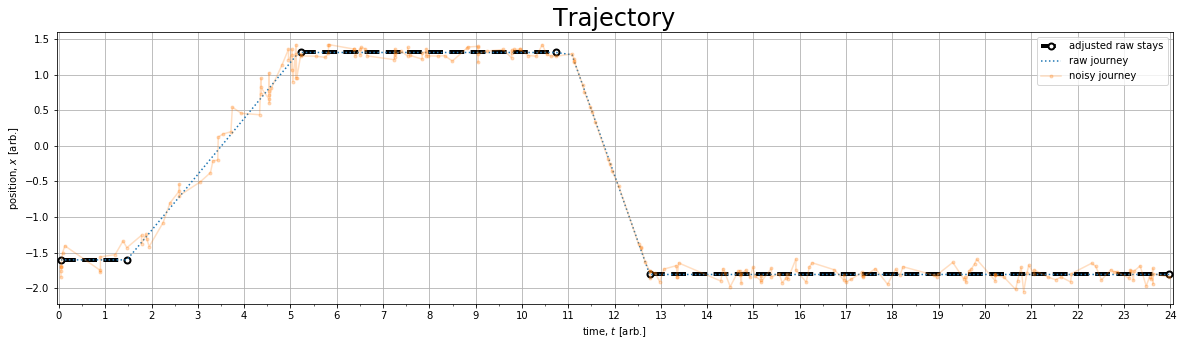

In [11]:
plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

# Clustering

## Get intial clusters

## Split the clusters which have a temporal gap

In [12]:
time_thresh = 1/6
eps=0.25

In [13]:
clusters = list(range(time_arr.size))

In [14]:
get_err = lambda x1, x2: np.sqrt((x1-x2)**2) 

In [15]:
def get_clusters(times, positions, dist_thresh, time_thresh):

    clusters = []

    m = 0

    new_cluster = []
    for n in range(0,positions.size-3):

        # Check the time
        if times[n+1] <= times[n]+time_thresh:

            get_y = positions[n+1]

        else: 
            continue

        # Get the current cluster mean
        cluster_mean = np.mean(positions[m:n+1])

        # Get the potential cluster mean    
        new_cluster_mean = np.mean(positions[m:n+2])

        err1 = get_err(cluster_mean, get_y)
        err2 = get_err(cluster_mean, new_cluster_mean)

        #print(n, err1, err2, dist_thresh)

        if  (err1 < dist_thresh) & (err2 < dist_thresh) & \
            (n <= positions.size-5):

            new_cluster.append(n)
            #print(len(new_cluster))
        else:
            txt = f'Trying {n} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (times[new_cluster[-1]]-times[new_cluster[0]] > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
            #print(txt+app)

            new_cluster = []

            m=n+1
            
    return clusters

In [16]:
clusters = get_clusters(time_arr,noise_arr, eps, time_thresh)
len(clusters)

4

In [17]:
for clust in clusters:
    print(clust)

[7, 8, 11, 13, 14, 15, 16]
[33, 34, 36, 37, 38, 39, 40]
[53, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 86, 88, 89, 90, 94, 95, 96, 97, 98, 101, 102, 103, 104, 106, 107, 108]
[123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 151, 152, 153, 154, 156, 158, 159, 162, 163, 164, 166, 167, 168, 172, 173, 175, 176, 179, 180, 181, 182, 183, 184, 186, 187, 188, 191, 192, 193, 194, 195, 196, 197, 200, 202, 204, 205, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218]


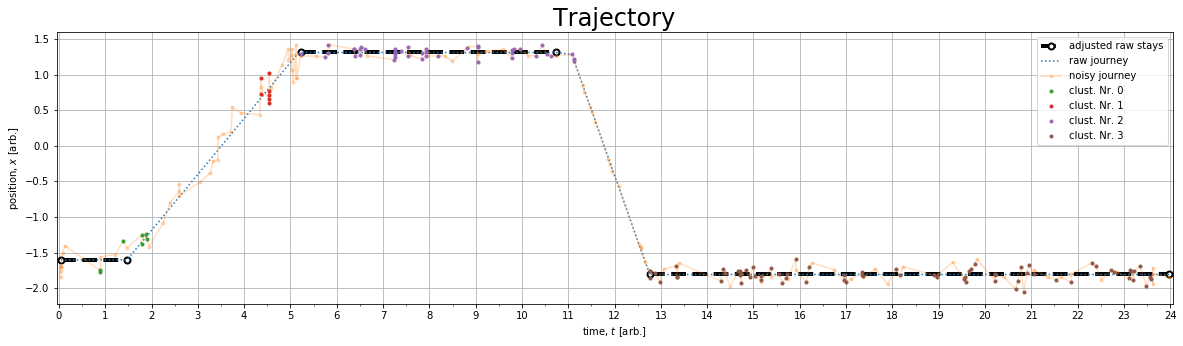

In [18]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters):
    ax.plot(time_arr[clust], noise_arr[clust], '.', alpha=0.95, label=f'clust. Nr. {cl_nr}')
ax.legend();

### Experimenting with IQR

In [19]:
m=0
nn=117
q25 = np.quantile(noise_arr[m:nn],0.25, interpolation='lower')
q75 = np.quantile(noise_arr[m:nn],0.75, interpolation='higher')

print(np.quantile(noise_arr[m:nn],[0.25, 0.5, 0.75], interpolation='higher'))
#print()

#print(np.sort(noise_arr[m:nn]))
# Interquartile range

iqr = abs(q75 - q25)
iqr_fact = 1.5

print()
print(q25, q75, iqr,(q25 - iqr_fact * iqr), (q75 + iqr_fact * iqr))
iqr_fact = 0
print(m, nn, np.where((noise_arr[m:nn] > (q25 - iqr_fact * iqr)) & (noise_arr[m:nn] < (q75 + iqr_fact * iqr))))
mask=np.where((noise_arr[m:nn] > (q25 - iqr_fact * iqr)) & (noise_arr[m:nn] < (q75 + iqr_fact * iqr)))
print(noise_arr[m:nn].size, np.std(noise_arr[m:nn]),noise_arr[mask].size, np.std(noise_arr[mask]))

[0.12453829 1.21008799 1.3059702 ]

0.12453828994376648 1.3059702035196321 1.1814319135758655 -1.6476095804200317 3.0781180738834304
0 117 (array([ 28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  44,  45,  46,  48,  50,  51,  52,  53,  54,  55,  56,
        62,  64,  67,  68,  71,  72,  74,  76,  77,  80,  82,  83,  84,
        85,  89,  91,  94, 100, 101, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114]),)
117 1.0540791969200567 57 0.32028126321917966


In [20]:
def get_iqr_masked(positions, iqr_fact = 3):
    # Calculate first and third quartiles
    q25 = np.quantile(positions,0.25, interpolation='lower')
    q75 = np.quantile(positions,0.75, interpolation='higher')

    # Calculate the interquartile range (IQR)
    iqr = abs(q75 - q25)

    #print(m, nn, np.where((yyyy[m:nn] > (q25 - iqr_fact * iqr)) & (yyyy[m:nn] < (q75 + iqr_fact * iqr))))
    mask=np.where(  (positions > (q25 - iqr_fact * iqr)) \
                  & (positions < (q75 + iqr_fact * iqr)))    
    
    return mask

def get_iqr_std(positions, iqr_fact = 3):
    
    mask=get_iqr_masked(positions, iqr_fact)
    
    return np.std(positions[mask])

In [21]:
def get_batch_clusters(times, positions, dist_thresh, time_thresh, iqr_fact=3.0):

    max_len = positions.size-6
    
    clusters = []

    ind = 0
    
    cluster = [0]
    
    last_time_point = times[cluster[0]]

    m = 0    
    
    while ind < max_len:

        
        # Set the time buffer around the last point of the current cluster
        nn=m+1
        while (times[nn]-last_time_point <= time_thresh) & (nn<=max_len):
            nn+=1

        #print(m,nn, positions[m:nn].shape)
        
        if positions[m:nn].size > 1:
            
            # Get the current cluster std
            cluster_std = np.std(positions[m:nn])
            cluster_qstd = get_iqr_std(positions[m:nn],iqr_fact)
            
        else:
            cluster_std = 0.0
            cluster_qstd = 0.0
        
        nnn=nn
        while ((positions[m:nnn].size > 1) & ((cluster_std >= dist_thresh) | (cluster_qstd >= dist_thresh))):
            print('\t\trefinement', nnn, cluster_std, cluster_qstd)
            # Get the current cluster std
            cluster_std = np.std(positions[m:nnn])
            cluster_qstd = get_iqr_std(positions[m:nnn],iqr_fact)
            nnn-=1

        # Check!
        print('STD-testing at', nn, cluster_std, cluster_qstd, dist_thresh)
        # 
        new_cluster = list(range(m,nnn+1))

        # if the std's are good, keep the cluster, and update the final time point
        if  (cluster_std < dist_thresh) & (cluster_qstd < dist_thresh) & (nnn<max_len) & (nnn==nn) :

            last_time_point = times[nnn]
            ind = nnn

        else:
            txt = f'Trying {len(new_cluster)} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (times[new_cluster[-1]]-times[new_cluster[0]] > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
            print(txt+app)

            new_cluster = []
            if (nnn==nn):
                ind=nn
                m=nn
            else:
                ind=nnn
                m=nnn
            
    return clusters

In [22]:
clusters = get_batch_clusters(time_arr,noise_arr,eps, time_thresh, 1.5)
len(clusters)

STD-testing at 7 0.1398669384501923 0.1398669384501923 0.25
STD-testing at 10 0.1293693563002904 0.1293693563002904 0.25
STD-testing at 11 0.12981596187908873 0.12981596187908873 0.25
STD-testing at 13 0.15548101154322005 0.15548101154322005 0.25
STD-testing at 18 0.1895360483075434 0.1895360483075434 0.25
		refinement 20 0.2559205082390139 0.2559205082390139
		refinement 19 0.2559205082390139 0.2559205082390139
STD-testing at 20 0.21034952589889427 0.21034952589889427 0.25
Trying 19 closed
STD-testing at 20 0.13700656733012995 0.13700656733012995 0.25
STD-testing at 23 0.18520027726536267 0.09650912388590055 0.25
STD-testing at 24 0.19203419907597008 0.19203419907597008 0.25
		refinement 27 0.26721217565717537 0.26721217565717537
		refinement 26 0.26721217565717537 0.26721217565717537
STD-testing at 27 0.24907155420084395 0.24907155420084395 0.25
Trying 8 closed
STD-testing at 27 0.004820305484763171 0.004820305484763171 0.25
STD-testing at 29 0.17642222199238433 0.17642222199238433 0

9

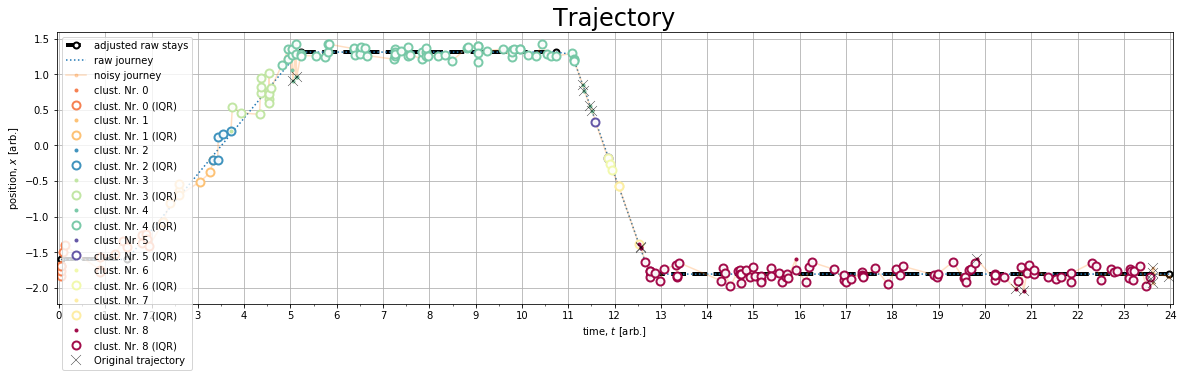

In [23]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

iqr_points_kwargs={'marker':'o', 'markeredgewidth':2.0, 'markerfacecolor':'w', 
                   'linestyle':'', 'color':'k', 'markersize':8.0, 'alpha':0.95, 
                   'label':'label'}

all_points_kwargs={'marker':'.', 'markeredgewidth':2.0, 'markerfacecolor':'w', 
                   'linestyle':'', 'color':'k', 'markersize':4.0, 'alpha':0.95, 
                   'label':'label'}

    
def get_new_kwargs(kwargs_dct):
    
    def meth(color, label):
        kwargs_dct.update({'color':color,'label':label})
        return kwargs_dct
    return meth
        
pdf = pd.DataFrame()
pdf_all = pd.DataFrame({'x':time_arr,'y':noise_arr})

for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]   
    
    xs = time_arr[clust]
    ys = noise_arr[clust]
    
    label=f'clust. Nr. {cl_nr}'
    ax.plot(xs, ys, **get_new_kwargs(all_points_kwargs)(color,label))
    
    label=f'clust. Nr. {cl_nr} (IQR)'
    mask=get_iqr_masked(ys,1)
    ax.plot(xs[mask], ys[mask], **get_new_kwargs(iqr_points_kwargs)(color,label))

    pdf1  = pd.DataFrame({'x':xs[mask],'yy':ys[mask]})
    #pdf2  = pd.DataFrame({'x':rxs[rmask],'y':rys[rmask]})
    #pdf = pdf1.merge(pdf2, on=['x'], how='outer')
    pdf = pd.concat([pdf,pdf1])

# plot the rest of the samples
pdf_all = pdf_all.merge(pdf, on=['x'], how='outer')
pdf_all['keep'] = pdf_all.yy.apply(np.isnan)
pdf_sub = pdf_all[pdf_all['keep']]
ax.plot(pdf_sub.x.values, pdf_sub.y.values, alpha=0.95, linestyle='',color='k', marker='x', markersize=10.0, markeredgewidth=0.40, linewidth=0.50, label='Original trajectory')

ax.legend();

In [24]:
clusters_rev = get_batch_clusters(np.max(time_arr)-time_arr[::-1],noise_arr[::-1],0.6,time_thresh, 1.5)
len(clusters_rev)

STD-testing at 1 0.0 0.0 0.6
STD-testing at 7 0.07832885237857042 0.07832885237857042 0.6
STD-testing at 10 0.08716066803119124 0.08716066803119124 0.6
STD-testing at 13 0.08275381848191696 0.08275381848191696 0.6
STD-testing at 16 0.07854005107945813 0.07854005107945813 0.6
STD-testing at 18 0.08087745736960687 0.08087745736960687 0.6
STD-testing at 19 0.08628104442230704 0.08628104442230704 0.6
STD-testing at 21 0.0855192590349058 0.0855192590349058 0.6
STD-testing at 23 0.08350883159815126 0.08350883159815126 0.6
STD-testing at 24 0.08202220859702827 0.08202220859702827 0.6
STD-testing at 28 0.08060773337041924 0.08060773337041924 0.6
STD-testing at 31 0.0915002520783746 0.0915002520783746 0.6
STD-testing at 32 0.09699316762729121 0.09699316762729121 0.6
STD-testing at 33 0.09561794389500071 0.09561794389500071 0.6
STD-testing at 37 0.09127078511739865 0.09127078511739865 0.6
STD-testing at 40 0.09833570261575854 0.09833570261575854 0.6
STD-testing at 44 0.09604943230443676 0.096049

3

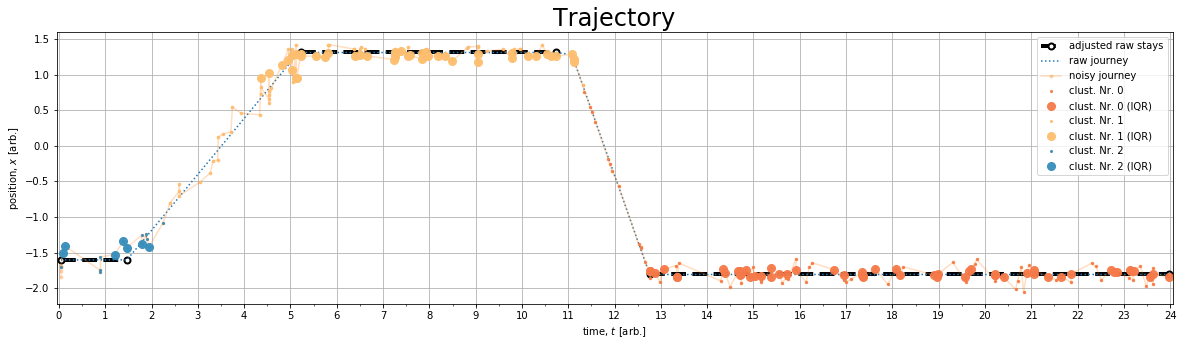

In [25]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters_rev):
    
    xs = time_arr[::-1][clust]
    ys = noise_arr[::-1][clust]
    
    ax.plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    iqr_fact = 0
    
    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]  
    ax.plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    
ax.legend();

2.250277777777778 0.043611111111111114
0.043611111111111114 2.250277777777778
11.311944444444444 2.250277777777778
2.250277777777778 11.311944444444444
23.976944444444445 11.311944444444444
11.311944444444444 23.976944444444445


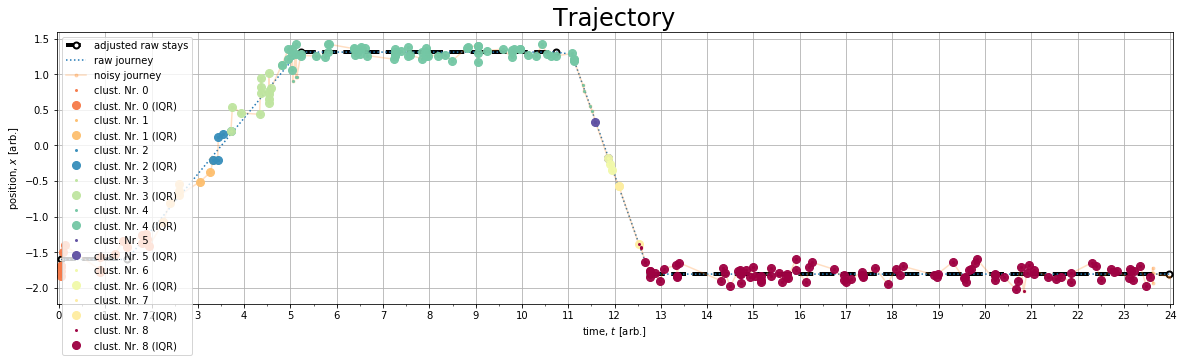

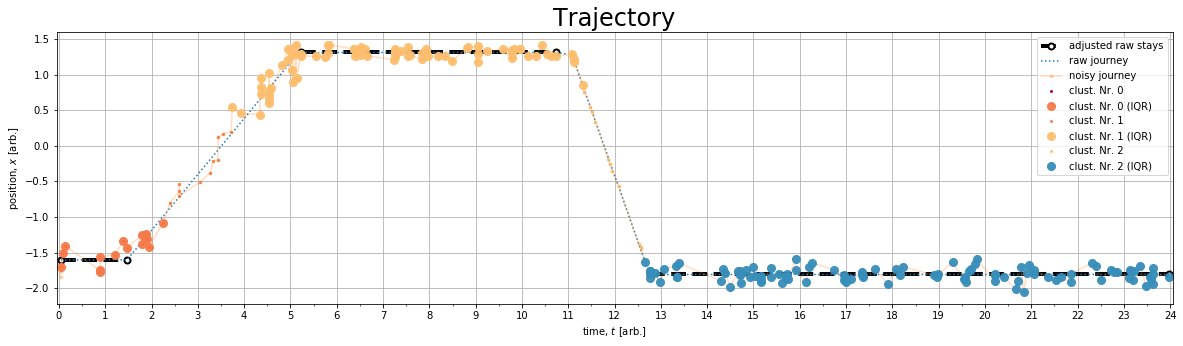

In [26]:

ax = np.array([None,None])
ax = ax.reshape(2,)

ax[0] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax[1] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters):
    
    xs = time_arr[clust]
    ys = noise_arr[clust]
    color=colors[cl_nr%len(colors)]    
    ax[0].plot(xs, ys, '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 1.5

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]
    ax[0].plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[0].legend()
    
for cl_nr, clust in enumerate(clusters_rev[::-1]):

    xs = time_arr[::-1][clust]
    ys = noise_arr[::-1][clust]
    
    print(xs[0],xs[-1])    
    xs = xs[::-1]
    print(xs[0],xs[-1])
    
    ys = ys[::-1]
    ax[1].plot(xs, ys, '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 1.5

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]    
    ax[1].plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[1].legend();

## Notes
* need to ensure the time-backward trajectory works in roughly the same way as the time-forward one
* need to have something that merges nearby clusters if they are close enough in time and space

2.250277777777778 0.043611111111111114
0.043611111111111114 2.250277777777778
11.311944444444444 2.250277777777778
2.250277777777778 11.311944444444444
23.976944444444445 11.311944444444444
11.311944444444444 23.976944444444445
0.043611111111111114 2.250277777777778
0.043611111111111114 2.250277777777778
2.250277777777778 3.3272222222222223
2.250277777777778 3.3272222222222223
3.3272222222222223 3.7152777777777777
3.3272222222222223 3.7152777777777777


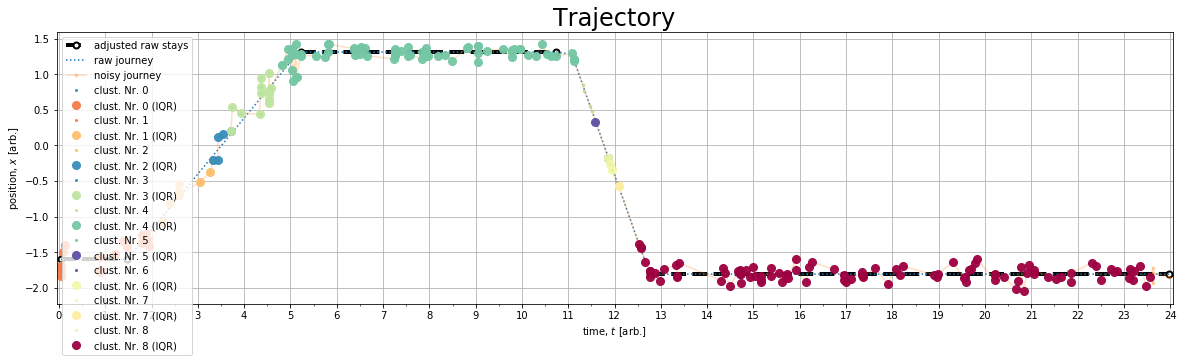

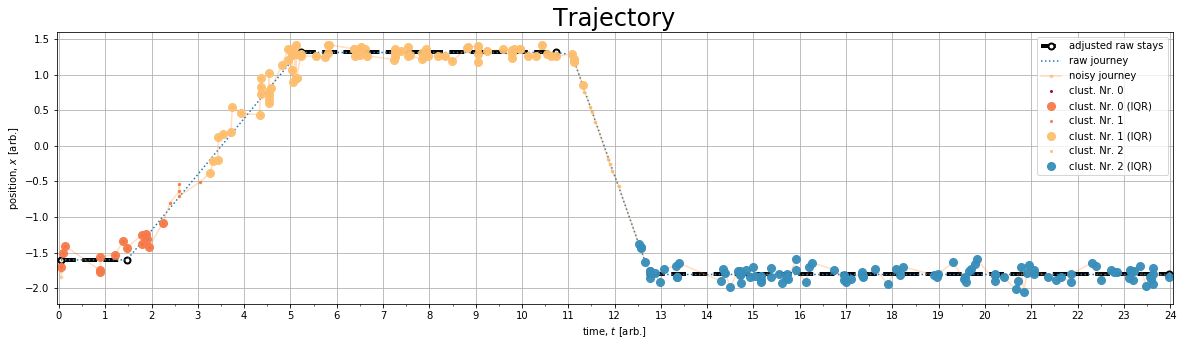

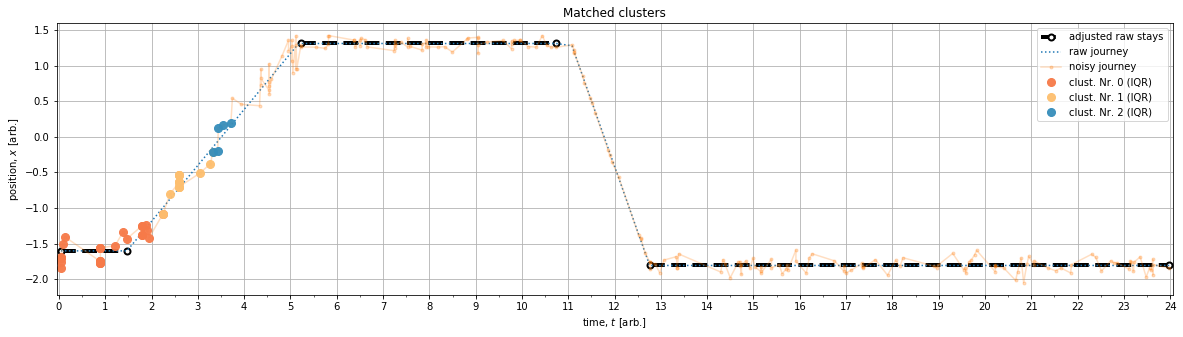

In [27]:
ax = np.array([None,None,None])
ax = ax.reshape(3,)

ax[0] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax[1] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax[2] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);


get_match = lambda x,y: (np.isnan(x) | np.isnan(x))
get_val = lambda x,y: x if np.isnan(x)==False else y

cl_nr = 0


for cl_nr, clust in enumerate(clusters):
    
    xs = time_arr[clust]
    ys = noise_arr[clust]
    
    ax[0].plot(xs, ys, '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]    
    ax[0].plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[0].legend()
    
for cl_nr, clust in enumerate(clusters_rev[::-1]):

    xs = time_arr[::-1][clust]
    ys = noise_arr[::-1][clust]
    
    print(xs[0],xs[-1])    
    xs = xs[::-1]
    print(xs[0],xs[-1])
    
    ys = ys[::-1]
    ax[1].plot(xs, ys, '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]    
    ax[1].plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[1].legend();
    
cl_nr = 0
for clust, rclust in zip(clusters,clusters_rev[::-1]):
    
    xs = time_arr[clust]
    ys = noise_arr[clust]
    
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    pdf1  = pd.DataFrame({'x':xs[mask],'y':ys[mask]})

    
    rxs = time_arr[::-1][rclust]
    rys = noise_arr[::-1][rclust]
    
    print(xs[0],xs[-1])    
    rxs = rxs[::-1]
    print(xs[0],xs[-1])
    
    rys = rys[::-1]

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    rmask=np.where((rys > (q25 - iqr_fact * iqr)) & (rys < (q75 + iqr_fact * iqr)))

    
    pdf2  = pd.DataFrame({'x':rxs[rmask],'ry':rys[rmask]})    
    
    pdf = pdf1.merge(pdf2, on=['x'], how='outer')
    #pdf = pd.concat([pdf,pdf1.merge(pdf2, on=['x'], how='outer')])
    
    pdf['matched'] = pdf.apply(lambda x: get_match(x['y'],x['ry']), axis=1)
    pdf['yy'] = pdf.apply(lambda x: get_val(x['y'],x['ry']), axis=1)

    color=colors[cl_nr%len(colors)]    
    ax[2].plot(pdf[pdf['matched']==False].x.values, pdf[pdf['matched']==False].y.values, 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    #ax[2].plot(pdf[pdf['matched']].x.values, pdf[pdf['matched']].yy.values, '.', alpha=0.95, color='k', markersize=4.0, label=None)


    ax[2].legend();    
    ax[2].set_title('Matched clusters')
    
    cl_nr += 1

In [28]:
pdf.head()

,x,y,ry,matched,yy
0,3.327222,-0.210405,NaN,False,-0.210405
1,3.430278,-0.200764,NaN,False,-0.200764
2,3.441111,0.124538,NaN,False,0.124538
3,3.551389,0.167258,NaN,False,0.167258
4,3.715278,0.197719,NaN,False,0.197719


In [29]:
1

1